## Figures for rstap paper

In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime

import copy
import dask
from glob import glob
import pickle


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams["font.family"] = "Arial"
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

# from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc').isel(time=0)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (grid.coords['lon'] > lonmin) 
    & (grid.coords['lon'] < lonmax)
    & (grid.coords['lat'] > latmin)
    & (grid.coords['lat'] < latmax)
)

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

## keep cice 2018 output because of detailed grid
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

latslice=slice(300,384)

def npolarplot(lowlat):
    proj = ccrs.NorthPolarStereo()#central_longitude=179-360)
    ax = plt.subplot(projection=proj)
    ax.coastlines(alpha=0.2,lw=1)
    ax.set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


## Observations
- First load reference files, including model dat 

In [2]:
# ## reference files

# # cice 2018 output because of grid with area
# mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
# cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
# cice18.TLAT[:] = grid.lat # hack to fix polar stereo
# cice18.TLON[:] = grid.lon
# tarea = cice18.tarea.rename(
#     {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)
# del cice18

# ## NH sea ice latitudes on curvilinear grid
# latslice = slice(300,384)

# ## revised mask for beaufort over tighter region
# ## old output from distance calculation, using wavewatch data originally
# dist_model = xr.open_dataarray(
#     '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 
# latmin = 72
# latmax = 79
# lonmin = 195
# lonmax = 230
# beau_mask = (
#     (dist_model.coords['longitude'] > lonmin) 
#     & (dist_model.coords['longitude'] < lonmax)
#     & (dist_model.coords['latitude'] > latmin)
#     & (dist_model.coords['latitude'] < latmax)
# )
# del dist_model

In [3]:
# ## Beaufort Sea data for 2012-2019
ww_allbeau = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc')
ww_allbeau = ww_allbeau.rename({'distance':'dist'})
# ## note that when we load in the the 2012-2019 dataset from the new run,
# ## we still keep the "ww1719" naming convention from when we only had 
# ## spectral output from 2017-2019. This is annoying because the '1719'
# ## is a misnomer, but this way the analysis code didnt need to be changed
# ## with the new run.
# ww1719ef_beau_cat = ww_allbeau
# ww1719beau_cat = ww_allbeau

# ## Global data as separate datasets for 2012-2019
# ## load and concat data 
# ww2012 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc')
# ww2013 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc')
# ww2014 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc')
# ww2015 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc')
# ww2016 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc')
# ww2017 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc')
# ww2018 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc')
# ww2019 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc')

# ww_dict = {'ww2012' : ww2012,
#            'ww2013' : ww2013,
#            'ww2014' : ww2014,
#            'ww2015' : ww2015,
#            'ww2016' : ww2016,
#            'ww2017' : ww2017,
#            'ww2018' : ww2018,
#            'ww2019' : ww2019}

# temp_f = xr.open_dataset('/glade/u/home/vcooper/analysis/waveice/ww1719ef_beau_cat.nc')

# for key,val in ww_dict.items():
#     print(key)
#     val = val.rename({'UAX': 'uwnd',
#                 'UAY': 'vwnd',
#                 'ICE': 'ice',
#                 'HS':  'hs',
#                 'T02': 't02',
#                 'T0M1':'t0m1',
#                 'T01': 't01',
#                 'FP0': 'fp',
#                 'THM': 'dir',
#                 'EF':  'ef',
#                 'FREQ':'f',
#                 'NX':  'ni',
#                 'NY':  'nj'})
    
#     val['latitude'] = (['nj','ni'],grid.lat.values)
#     val['longitude'] = (['nj','ni'],grid.lon.values)
#     val = val.set_coords(['time','latitude','longitude'])
#     val['f'] = temp_f.f
#     val = val.sel(nj=latslice)
#     val['tarea'] = (['nj','ni'], tarea.sel(nj=latslice).values)
#     val.coords['mask'] = (('nj','ni'), beau_mask)
# #     val = val.where(val.mask > 0, drop=True) ## only keep if dropping to beau
#     ww_dict[key] = val
# ##########################################
# del temp_f

In [4]:
## read in new mooring data revised by Jim Thomson Nov 2021
BGOS_dir = '/glade/campaign/univ/uwas0070/vcooper/waveice/data_jthomson/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

longobs_dict = {'bgosA' : bgosA,
                'bgosD' : bgosD,
                'sodaA' : sodaA,
                'sodaB' : sodaB,
                'sodaC' : sodaC}

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

## SWIFT data
swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
ni = {}
for key,da in longobs_dict.items():
    
    ## code to find grid cell closest to lat lon obs
    templat = np.tile(da.lat.values.mean(),
                  tarea.latitude.values.size).reshape(tarea.latitude.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      tarea.longitude.values.size).reshape(tarea.longitude.values.shape) % 360
    difflat = templat - tarea.latitude.values
    difflon = templon - tarea.longitude.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

for key,da in swift_dict.items():
    
    ## code to find grid cell closest to lat lon of SWIFT obs
    templat = np.tile(da.lat.values.mean(),
                  tarea.latitude.values.size).reshape(tarea.latitude.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      tarea.longitude.values.size).reshape(tarea.longitude.values.shape) % 360
    difflat = templat - tarea.latitude.values
    difflon = templon - tarea.longitude.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

## repeat finding closest grid cell to the ob location, 
## but transform index to the reduced beaufort grid subset
nj_allbeau = {}
ni_allbeau = {}
for key,val in nj.items():
    nj_allbeau[key] = ww_allbeau.nj.where(
        ((ww_allbeau.latitude - tarea.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - tarea.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)
    ni_allbeau[key] = ww_allbeau.ni.where(
        ((ww_allbeau.latitude - tarea.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - tarea.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)

In [5]:
## load satellite distances

path = '/glade/campaign/univ/uwas0070/vcooper/waveice/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_2012-2020_cicegrid.nc' # name of regridded file

## this is the satellite ice conc. estimates
## I named it 'boot' because I originally thought it was the bootstrap data, but it really has
## CDR, bootstrap, and NASA team.
## CDR is used in this analysis, renamed with CICE convention for ease of code
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020.nc').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020_bt.nc').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020_nt.nc').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt])

# ## fix grid
dist_sat_all.TLON[:] = tarea.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = tarea.sel(nj=latslice).latitude.values

In [6]:
%%time

## exclude the nans
sodaA = sodaA.where(sodaA.sigwaveheight > 0, drop=True)
sodaB = sodaB.where(sodaB.sigwaveheight > 0, drop=True) 
sodaC = sodaC.where(sodaC.sigwaveheight > 0, drop=True) 
bgosA = bgosA.where(bgosA.sigwaveheight > 0, drop=True) 
bgosD = bgosD.where(bgosD.sigwaveheight > 0, drop=True) 

## repeat for swifts
for i,key in enumerate(swift_dict):
    swift_dict[key] = swift_dict[key].where(swift_dict[key].sigwaveheight > 0, drop=True)

CPU times: user 1.57 s, sys: 22.4 ms, total: 1.6 s
Wall time: 1.67 s


In [7]:
%%time
# Interpolate distances to make one dataset that matches exactly the in situ obs timing.
# Then create some dictionaries for ease of acccess.
alltimes = np.array([]) # make one array of all obs times
alltimes = np.hstack((bgosA.time.values,
                      bgosD.time.values,
                      sodaA.time.values,
                      sodaB.time.values,
                      sodaC.time.values))

## add SWIFT data
for key,da in swift_dict.items():
    alltimes = np.hstack((alltimes,da.time.values))
    
alltimes = np.unique(np.sort(alltimes)) # times in ascending order, remove duplicates

CPU times: user 6.67 ms, sys: 0 ns, total: 6.67 ms
Wall time: 6.68 ms


In [8]:
%%time
## Uncomment this line when switching back to 6 hourly resample
# dist_sat_interp = dist_sat_all.interp(time=alltimes)

## load the hourly version; comment this out when using 6 hourly
dist_sat_interp = xr.open_dataset('/glade/campaign/univ/uwas0070/vcooper/waveice/scratch_analysis/dist_sat_interp_obstimes.nc')

###### also interpolate concentrations
time_forinterp = slice('2012-01-01','2020-12-31')

boot_cdr_interptoinsitu = boot.aice_d.sel(nj=latslice,time=time_forinterp).interp(time=alltimes)

CPU times: user 26.3 s, sys: 11.1 s, total: 37.4 s
Wall time: 40.5 s


In [9]:
## create dictionary of distances at locations of obs
dist_dict = {}

## dictionaries for distance based on CDR, Boot, NASA Team, at obs locations
cdr_dict = {}
cdr_dict['bgosA'] = dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).cdr
cdr_dict['bgosD'] = dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).cdr
cdr_dict['sodaA'] = dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).cdr
cdr_dict['sodaB'] = dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).cdr
cdr_dict['sodaC'] = dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).cdr

bt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).bt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).bt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).bt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).bt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).bt}

nt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).nt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).nt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).nt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).nt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).nt}

## optional addition of SWIFT data -- additional key for each buoy deployed
for key,da in swift_dict.items():
    
    ## find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  tarea.latitude.values.size).reshape(tarea.latitude.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      tarea.longitude.values.size).reshape(tarea.longitude.values.shape) + 360
    difflat = templat - tarea.latitude.values
    difflon = templon - tarea.longitude.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    
    ## insert the ice distances into the distance dictionaries
    cdr_dict[key] = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).cdr
    bt_dict[key]  = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).bt
    nt_dict[key]  = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).nt

dist_dict.update({'cdr' : cdr_dict,
                  'bt'  : bt_dict,
                  'nt'  : nt_dict})

# easy indexing of obs datasets
insitu_dict = {'sodaA' : sodaA,
               'sodaB' : sodaB,
               'sodaC' : sodaC,
               'bgosA' : bgosA,
               'bgosD' : bgosD,
              }

## SWIFT version already exists as swift_dict, but combine for ease with functions
for key,da in swift_dict.items():
    insitu_dict[key] = da

In [10]:
%%time

for key,val in insitu_dict.items():
    
    # let's add the CDR distance to the insitu dataset too to simplify things, and SIC
    cdr = dist_dict['cdr'][key]
    sic = boot_cdr_interptoinsitu.sel(nj=nj[key]-latslice.start,ni=ni[key],time=insitu_dict[key].time)
    

    # update xarray
    insitu_dict[key] = xr.merge([val,cdr,sic])

CPU times: user 1.04 s, sys: 397 ms, total: 1.43 s
Wall time: 8.58 s


In [11]:
## load JRA winds at time nearest the obs

scratch_savepath = '/glade/campaign/univ/uwas0070/vcooper/waveice/scratch_analysis/'
# jra_v.sel(time=jratime[isel_alltimes]).to_netcdf(scratch_savepath + 'jra1.5_v10_2012-2020.nc')
# jra_u.sel(time=jratime[isel_alltimes]).to_netcdf(scratch_savepath + 'jra1.5_u10_2012-2020.nc')
# jra_v10 = jra_v.sel(time=jratime[isel_alltimes])
# jra_u10 = jra_u.sel(time=jratime[isel_alltimes])
jra_v10 = xr.open_dataset(scratch_savepath + 'jra1.5_v10_2012-2020.nc')
jra_u10 = xr.open_dataset(scratch_savepath + 'jra1.5_u10_2012-2020.nc')
jra_subset = xr.merge([jra_u10,jra_v10])
jra_subset['wind'] = (jra_subset.u_10**2 + jra_subset.v_10**2)**(0.5)
jra_subset['longitude'] = jra_subset.longitude

## Wind speed from equilibrium range
- following Voermans et al 2020 and Thomson et al 2012

In [12]:
## constants
Ip = 2.5 # Voermans 1.9 to 3.1 (wide to narrow, citing Juszko 95), 2.5 works (Thomson 2013)
vk = 0.41 # von karman constant
g = 9.81
beta = 0.009 # determined from Voermans et al 2020 figures, 0.012 is canonical

# or alpha determined below based on eq 16 in Voermans et al 2020 
# cp = g * T / (2*np.pi)
# alpha = 0.14*(ustar/cp)**0.61
# alternative: alpha = 0.012 # Charnock 1955

In [13]:
def calcu10(spec_dict, dmin, dmax, set_Ip):
    
    # feed it an empty dictionary
    setmin = 0.3 # minimum Hs
    Ip = set_Ip
    fpmin = 0.06
    Nlim = 10
    
    for key,tempds in insitu_dict.items():
        if ('SWIFT' not in key):
            print(key)

            subds = tempds.where((tempds.peakwaveperiod**(-1) > fpmin) &
                                       (tempds.sigwaveheight > 0.3) & 
                                       (tempds.cdr > dmin) & (tempds.cdr < dmax),drop=True)
            if (len(subds.time) < 1):
                continue
                
            spec_dict[key] = subds

            ## get jra
            templat = tempds.lat.values.mean()
            templon = tempds.lon.values.mean() % 360

            difflat = templat - jra_subset.latitude.values
            difflon = templon - jra_subset.longitude.values
            dlat,dlon = np.meshgrid(difflat,difflon)
            dist = dlat**2 + dlon**2

            lon_isel = np.where(dist == np.min(dist))[0][0]
            lat_isel = np.where(dist == np.min(dist))[1][0]

            jra_obstime = jra_subset.time.indexes['time'].to_datetimeindex().to_numpy()
            jra_time_isel = np.searchsorted(jra_obstime,tempds.time)
            tempds['jra_wind'] = ('time',
                                  jra_subset.isel(time=jra_time_isel,
                                                  latitude=lat_isel,
                                                  longitude=lon_isel).wind.values)

            spec_dict[key]['fp'] = ('time',1/spec_dict[key].peakwaveperiod)
            spec_dict[key]['ef_eq'] = spec_dict[key].wavespectra_energy.where(
                (tempds.freq_wavespectra > spec_dict[key].fp) & 
                (tempds.freq_wavespectra > 0.2))

            ## ef_eq forced to be above noise thresh; actually forced to be above 0.5 Hz
            ef_eq = spec_dict[key].ef_eq
            spec_dict[key]['cut_eq'] = spec_dict[key].ef_eq # dummy
            tempefeq = xr.where(ef_eq < 1.5*10**(-2),tempds.freq_wavespectra,0)
            tempefeq = xr.where(tempefeq > spec_dict[key].fp, tempefeq, 0)
            critf = xr.where(tempefeq > 0,tempefeq.freq_wavespectra,100).min(dim='freq_wavespectra')
    #         spec_dict[key]['cut_eq'] = ef_eq.where(critf > ef_eq.freq_wavespectra)
            spec_dict[key]['cut_eq'] = ef_eq.where(ef_eq.freq_wavespectra < 0.5)
            spec_dict[key]['N'] = xr.where(spec_dict[key].cut_eq > 0,1,0).sum(dim='freq_wavespectra')

            #### make multiple e0means starting at each N ## can cut this out if I want
            subds = spec_dict[key]
            Nchecklimit = 20
            Nchecks = subds.N.values - Nchecklimit + 1
            Nchecks = np.where(Nchecks > 0, Nchecks, 0)
            fstart_isel = xr.where(
                subds.cut_eq > 0,subds.freq_wavespectra,100).argmin(dim='freq_wavespectra')
            for i,val in enumerate(Nchecks):
                if val < 2:
                    continue

                hold_i = np.arange(fstart_isel.values[i],
                                   fstart_isel.values[i]+Nchecklimit,1)[np.newaxis,:].repeat(val,axis=0)
                hold_i += np.arange(0,val,1)[:,np.newaxis].repeat(Nchecklimit,axis=1)

                hold_f = subds.freq_wavespectra.values[hold_i.ravel()].reshape(hold_i.shape)
                hold_ef = subds.wavespectra_energy[i].values[hold_i.ravel()].reshape(hold_i.shape)
                hold_prod = hold_ef * hold_f**4
                hold_e0 = np.mean(hold_prod,axis=1)
                hold_se = np.mean((hold_prod - hold_e0[:,np.newaxis])**2,axis=1)**(0.5)
                f_nlim = hold_f[hold_se.argmin()]

                spec_dict[key].cut_eq[i] = subds.cut_eq[i].where(
                    subds.freq_wavespectra.isin(f_nlim))
            
            ## wind estimates
            spec_dict[key]['e0_mean'] = (spec_dict[key].cut_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
    #         spec_dict[key]['e0_mean'] = (spec_dict[key].ef_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
            ustar = spec_dict[key].e0_mean * (2*np.pi)**3 / (4 * beta * Ip * g)
            ## special alpha
            cp = g * spec_dict[key].peakwaveperiod / (2*np.pi)
            alpha = 0.14*(ustar/cp)**0.61 ## special alpha eq 16 from Voermans et al 2020
            spec_dict[key]['alpha'] = alpha
            z0 = alpha * ustar**2 / g # + 0.11 * nu / ustar (roughness length, ignoring first term)
            spec_dict[key]['u10est'] = ustar/vk * np.log(10 / z0)
            spec_dict[key]['jra'] = tempds.jra_wind.sel(time=spec_dict[key].u10est.time)

            ## RMSE
            spec_dict[key]['rmse'] = (
                (spec_dict[key].ef_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
                dim='freq_wavespectra')**(0.5)
            spec_dict[key]['rmse_cut'] = (
                (spec_dict[key].cut_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
                dim='freq_wavespectra')**(0.5)
            spec_dict[key]['se'] = spec_dict[key].rmse_cut * (
                2*np.pi)**3 / (4 * beta * Ip * g) / vk * np.log(10 / z0) # standard error in u10 m/s terms

            ## RMSLE
            p = spec_dict[key]['e0_mean'] # prediction
            a = spec_dict[key].ef_eq * tempds.freq_wavespectra**4 # actual
            a_cut = spec_dict[key].cut_eq * tempds.freq_wavespectra**4 # actual
            spec_dict[key]['rmsle'] = (
                (np.log(p + 1) - np.log(a + 1))**2).mean(dim='freq_wavespectra')**(0.5)
            spec_dict[key]['rmsle_cut'] = (
                (np.log(p + 1) - np.log(a_cut + 1))**2).mean(dim='freq_wavespectra')**(0.5)
            
            spec_dict[key]['obname'] = xr.DataArray(np.tile([key],len(ustar.time)), 
                                dims=subds.time.dims, coords = subds.time.coords)
            
    return(spec_dict)

In [14]:
%%time

## calculate EQ range U10 from open water and 100+ km dist

spec_d = {}
spec_d_open = {}
spec_d_open = calcu10(spec_d_open,-1,0.1,2.5)
spec_d = spec_d_open

spec_d_0to100 = {}
spec_d_0to100 = calcu10(spec_d_0to100,0,100,1.9)

spec_d_100 = {}
spec_d_100 = calcu10(spec_d_100,100,1e6,1.9)

sodaA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaB


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaC
bgosA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


bgosD


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaA
sodaB
sodaC
bgosA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle

bgosD
sodaA
sodaB
sodaC


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle

bgosA
bgosD
CPU times: user 20.7 s, sys: 283 ms, total: 21 s
Wall time: 24.7 s


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaA 1082
sodaB 295
bgosA 5796
bgosD 2481
sodaA 6
sodaB 0
sodaC 2
bgosA 70
bgosD 6


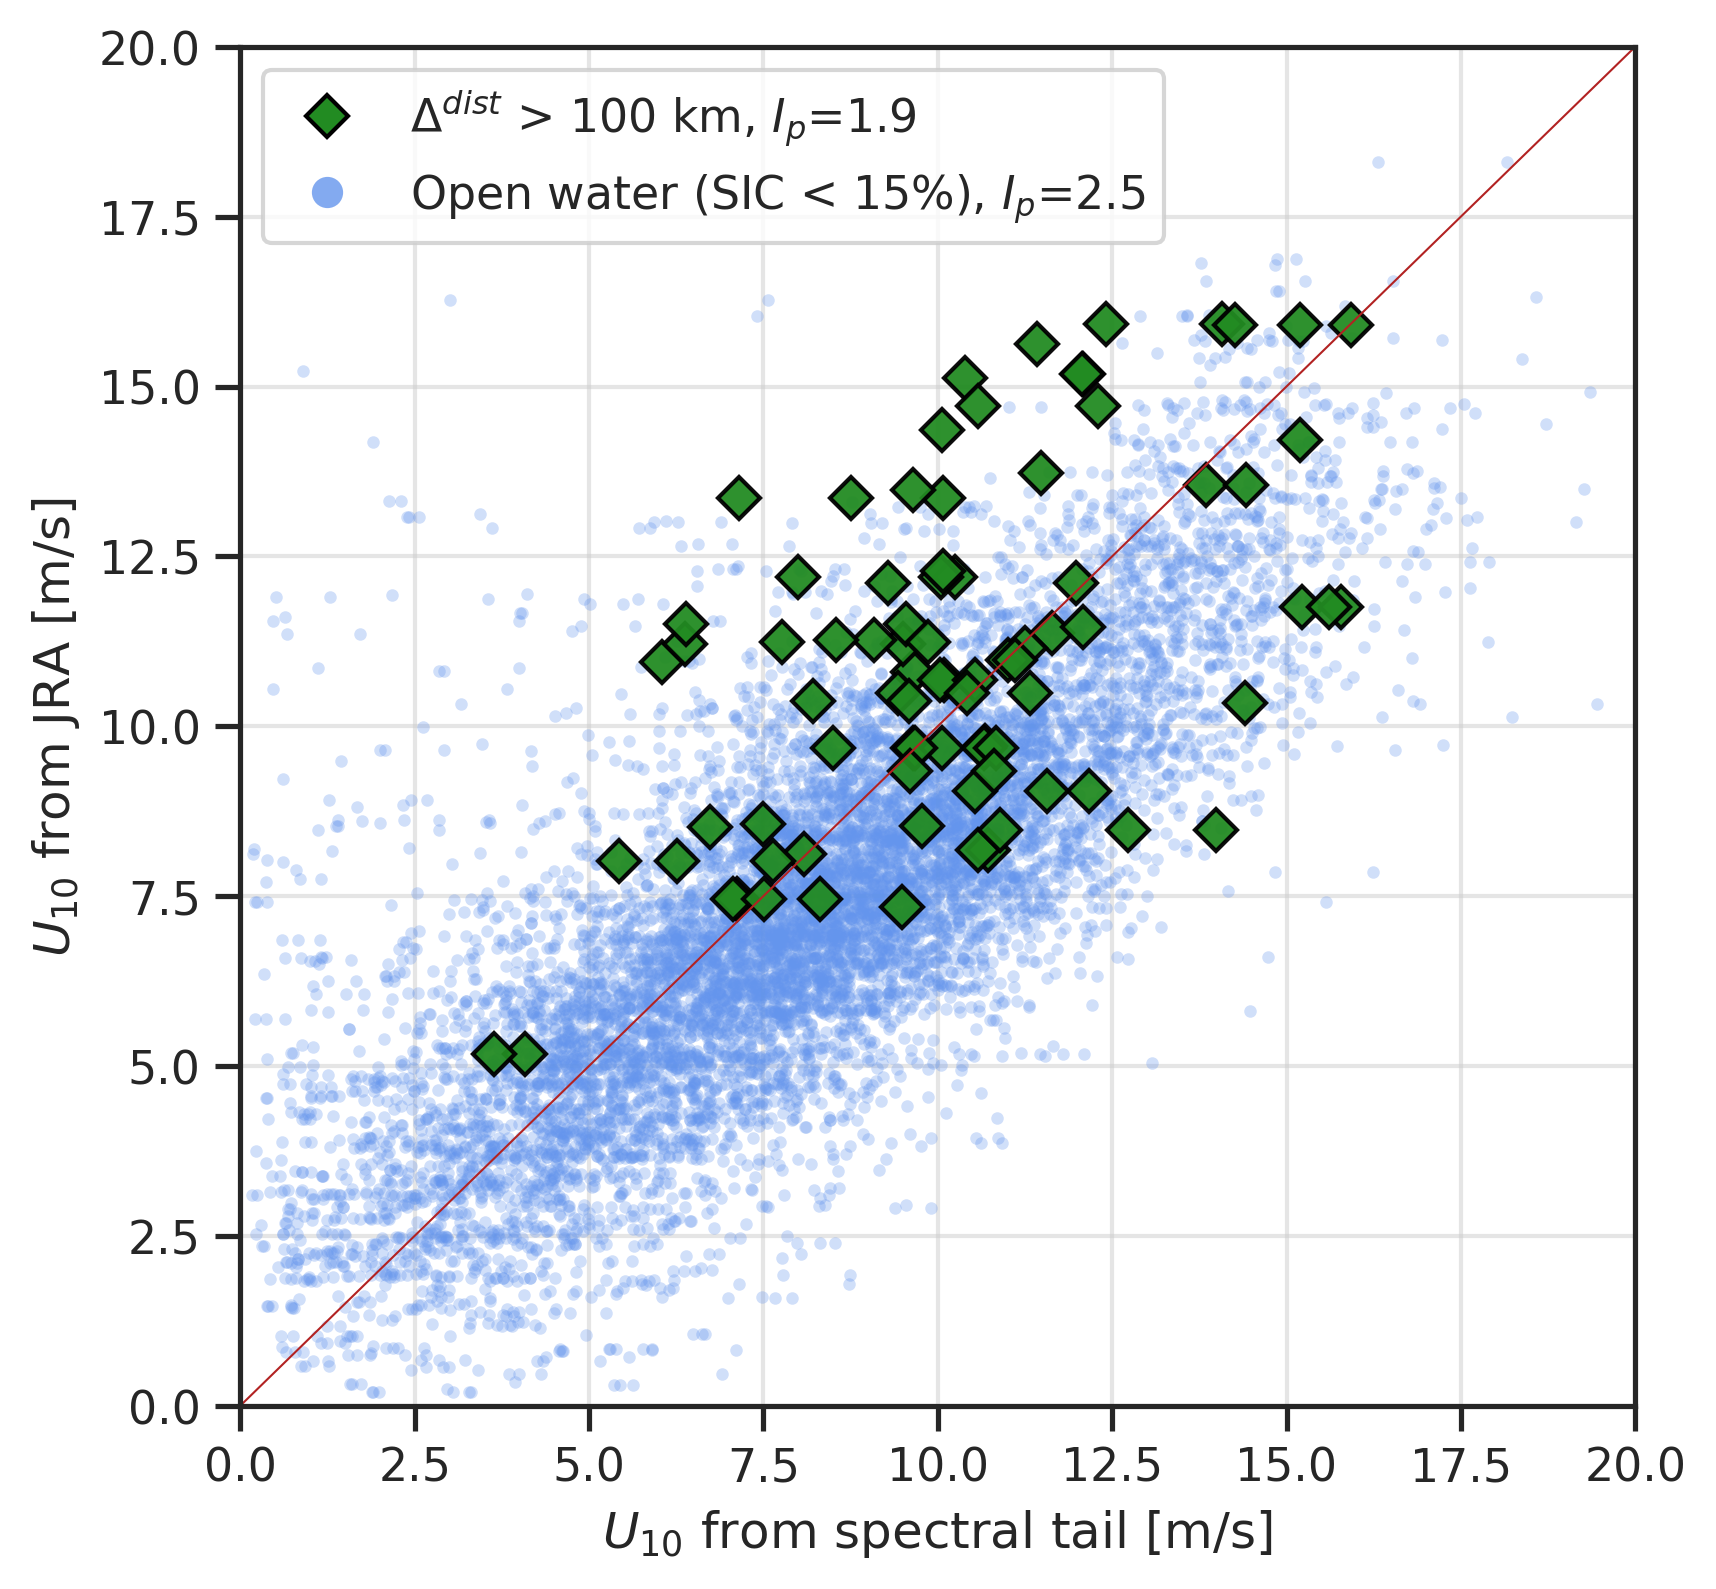

In [15]:
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6),dpi=300)

    for key,tempds in spec_d_open.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.3,mec='none',c='cornflowerblue',ms=6)
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1
        
    for key,tempds in spec_d_100.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),ms=7,
                 ls='',marker='D',alpha=0.95,mec='k',c='forestgreen')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    # dummy labels
    plt.plot(-1,-1,ls='',marker='D',ms=7,
             alpha=1,mec='k',c='forestgreen',label='$\Delta^{dist}$ > 100 km, $I_p$=1.9')
    plt.plot(-1,-1,ls='',marker='.',ms=15,
             alpha=0.8,mec='none',c='cornflowerblue',label='Open water (SIC < 15%), $I_p$=2.5')
    
    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('$U_{10}$ from spectral tail [m/s]')
    plt.ylabel('$U_{10}$ from JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    # plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

In [16]:
## make single dataset with all key parameters

def make_bulkds(spec_dtemp):
    varlist = ['sigwaveheight','fp','cdr','u10est','jra','e0_mean','rmse_cut','rmsle_cut','N','obname','aice_d']
    # bulk_ds = xr.concat([spec_dtemp['sodaA'][varlist], 
    #        spec_dtemp['sodaB'][varlist],
    #        spec_dtemp['sodaC'][varlist],
    #        spec_dtemp['bgosA'][varlist],
    #        spec_dtemp['bgosD'][varlist]],dim='time')
    bulk_ds = xr.concat([val[varlist] for key,val in spec_dtemp.items()], dim='time')
    # bulk_ds = bulk_ds.where(bulk_ds.N >= Nlim)
    bulk_ds = bulk_ds.set_coords('obname')
    bulk_ds = bulk_ds.where(~np.isnan(bulk_ds.u10est),drop=True)
    bulk_ds['err'] = bulk_ds.u10est - bulk_ds.jra
    return(bulk_ds)
    
bulk_ds_open = make_bulkds(spec_d_open)
bulk_ds_0to100 = make_bulkds(spec_d_0to100)
bulk_ds_100 = make_bulkds(spec_d_100)

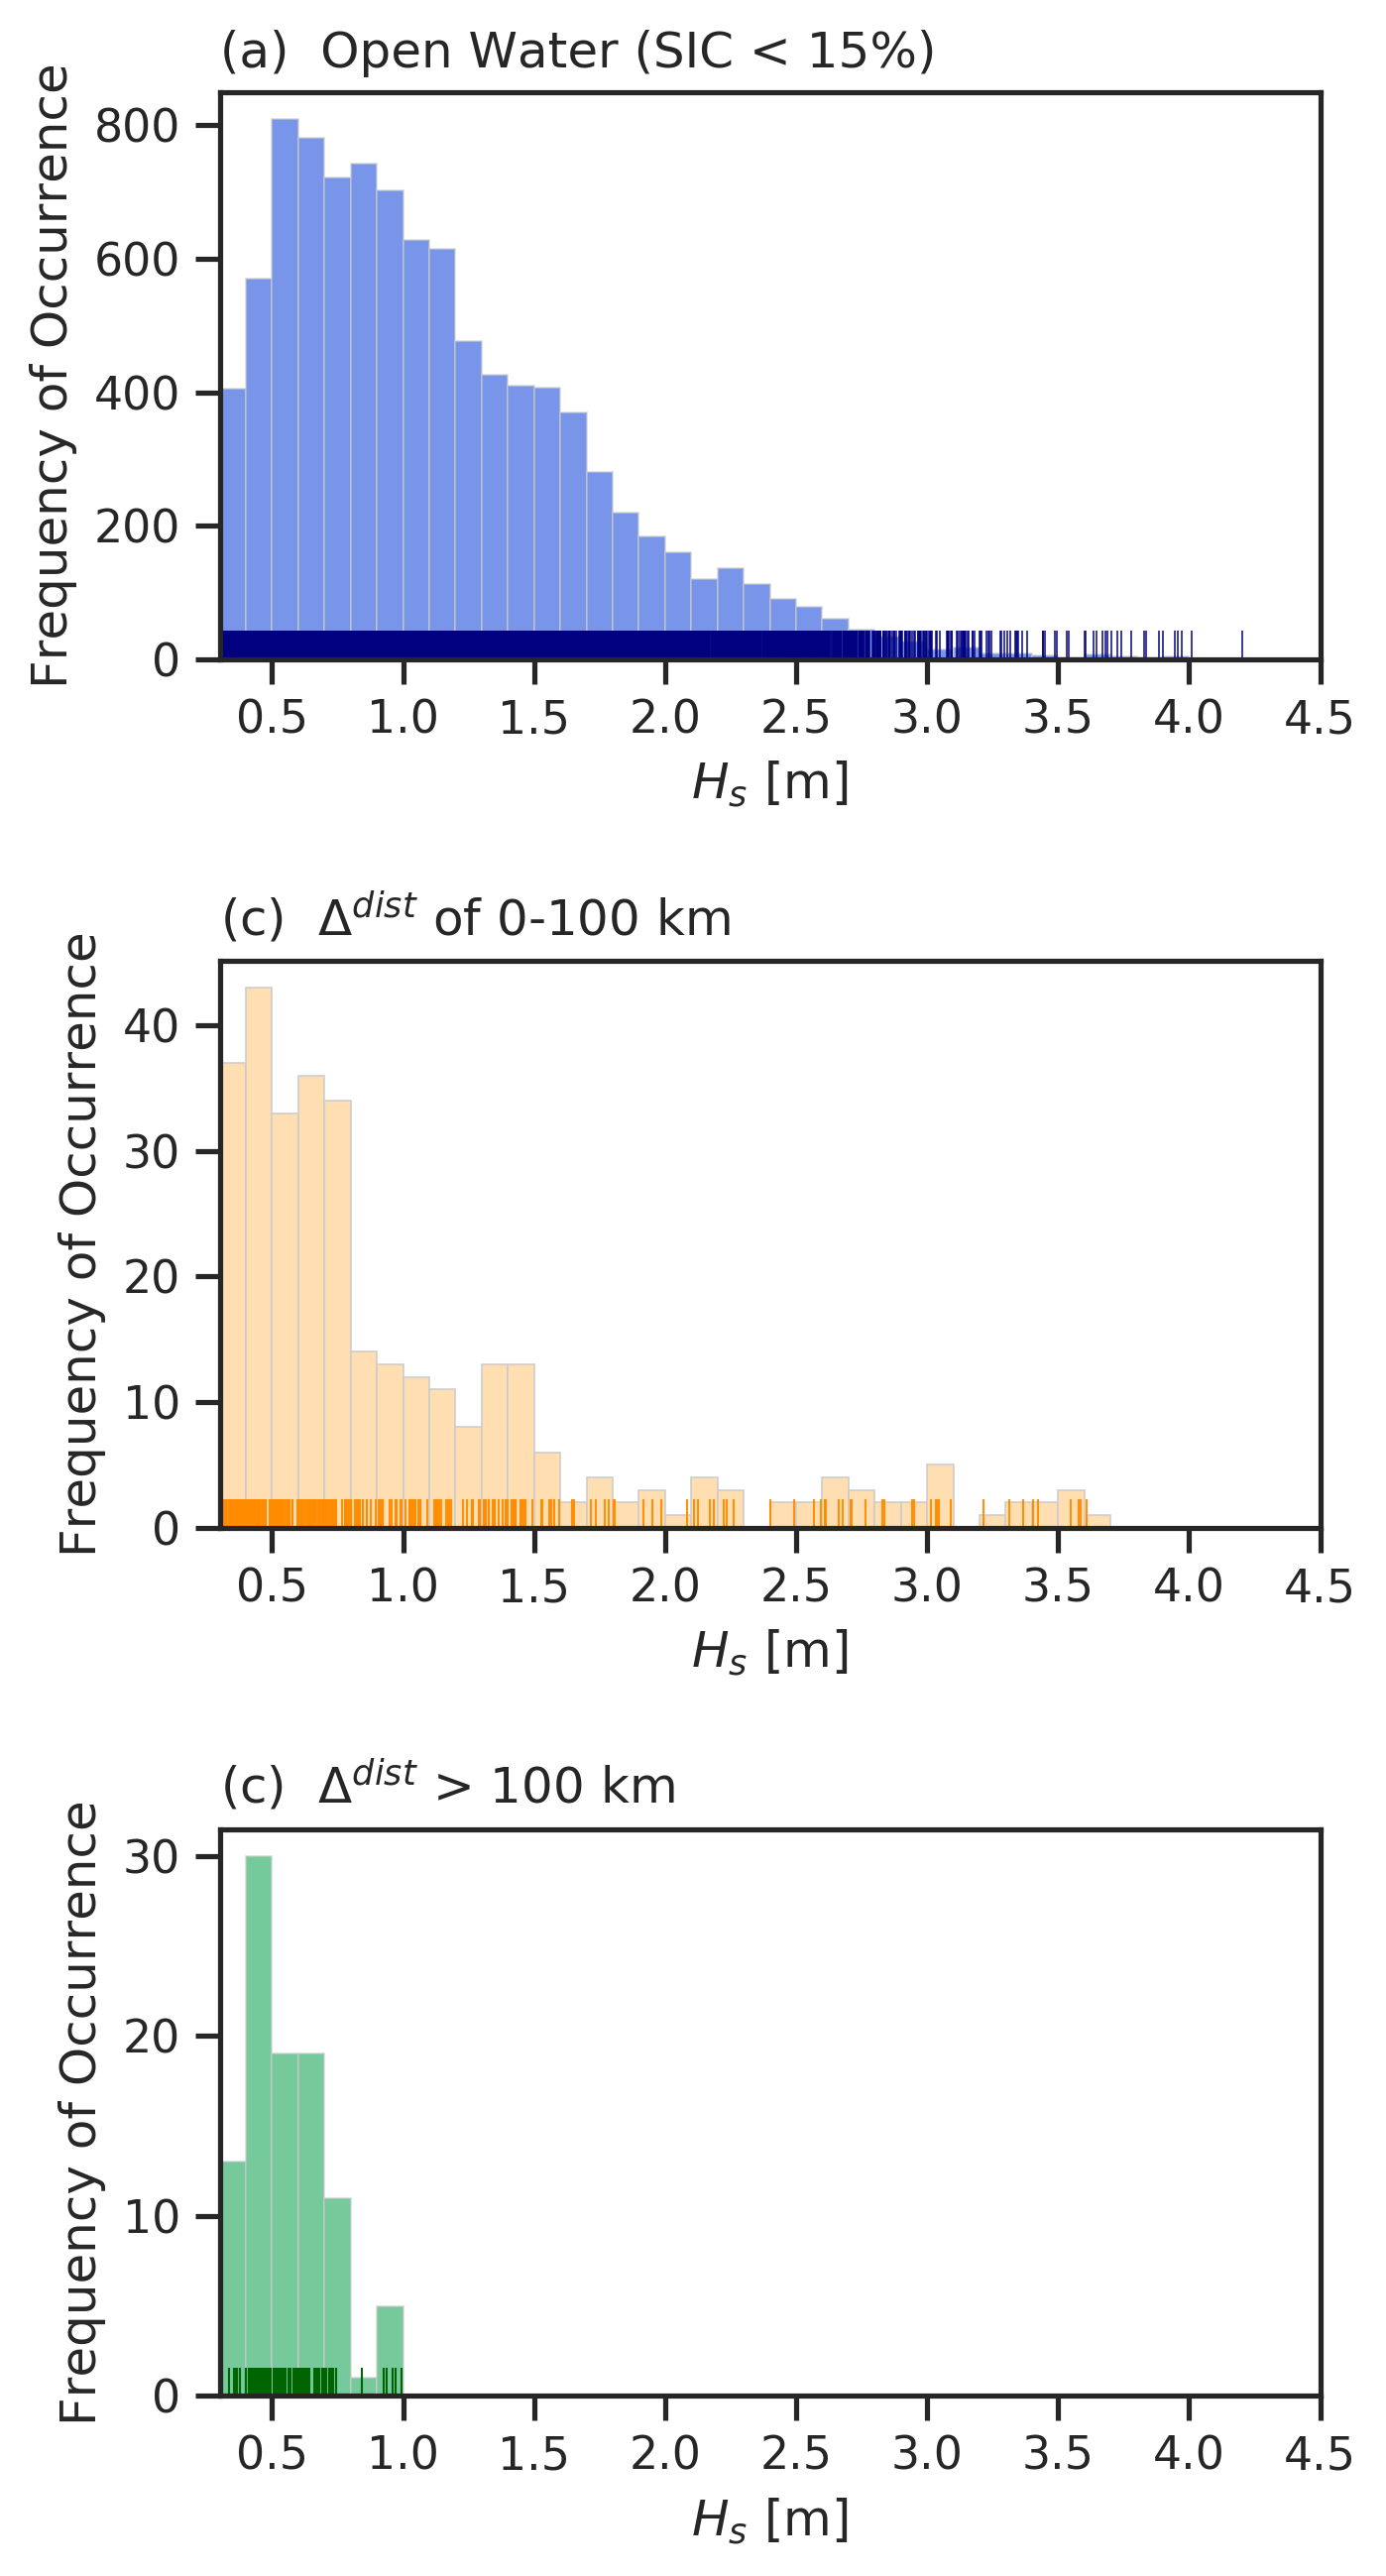

In [49]:
## 1d histogram obs and model
## BEAUFORT REGION

with sns.axes_style('ticks'):
    fig,ax = plt.subplots(3,1,figsize=(5,9),dpi=300) ## change to dpi 300 for press quality

    plt.sca(ax[0])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    obs_hs = bulk_ds_open.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='royalblue',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.7, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.9,'lw':0.4,'c':'navy'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(a)  Open Water (SIC < 15%)',loc='left')
    # plt.legend()

    ############
    plt.sca(ax[1])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    
    obs_hs = bulk_ds_0to100.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='navajowhite',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.95, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.95,'lw':0.5,'c':'darkorange'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(b)  $\Delta^{dist}$ of 0-100 km',loc='left')
    
    ############
    plt.sca(ax[2])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    
    obs_hs = bulk_ds_100.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='mediumseagreen',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.7, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.99,'lw':0.5,'c':'darkgreen'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(c)  $\Delta^{dist}$ > 100 km',loc='left')

    plt.tight_layout()
    plt.show()

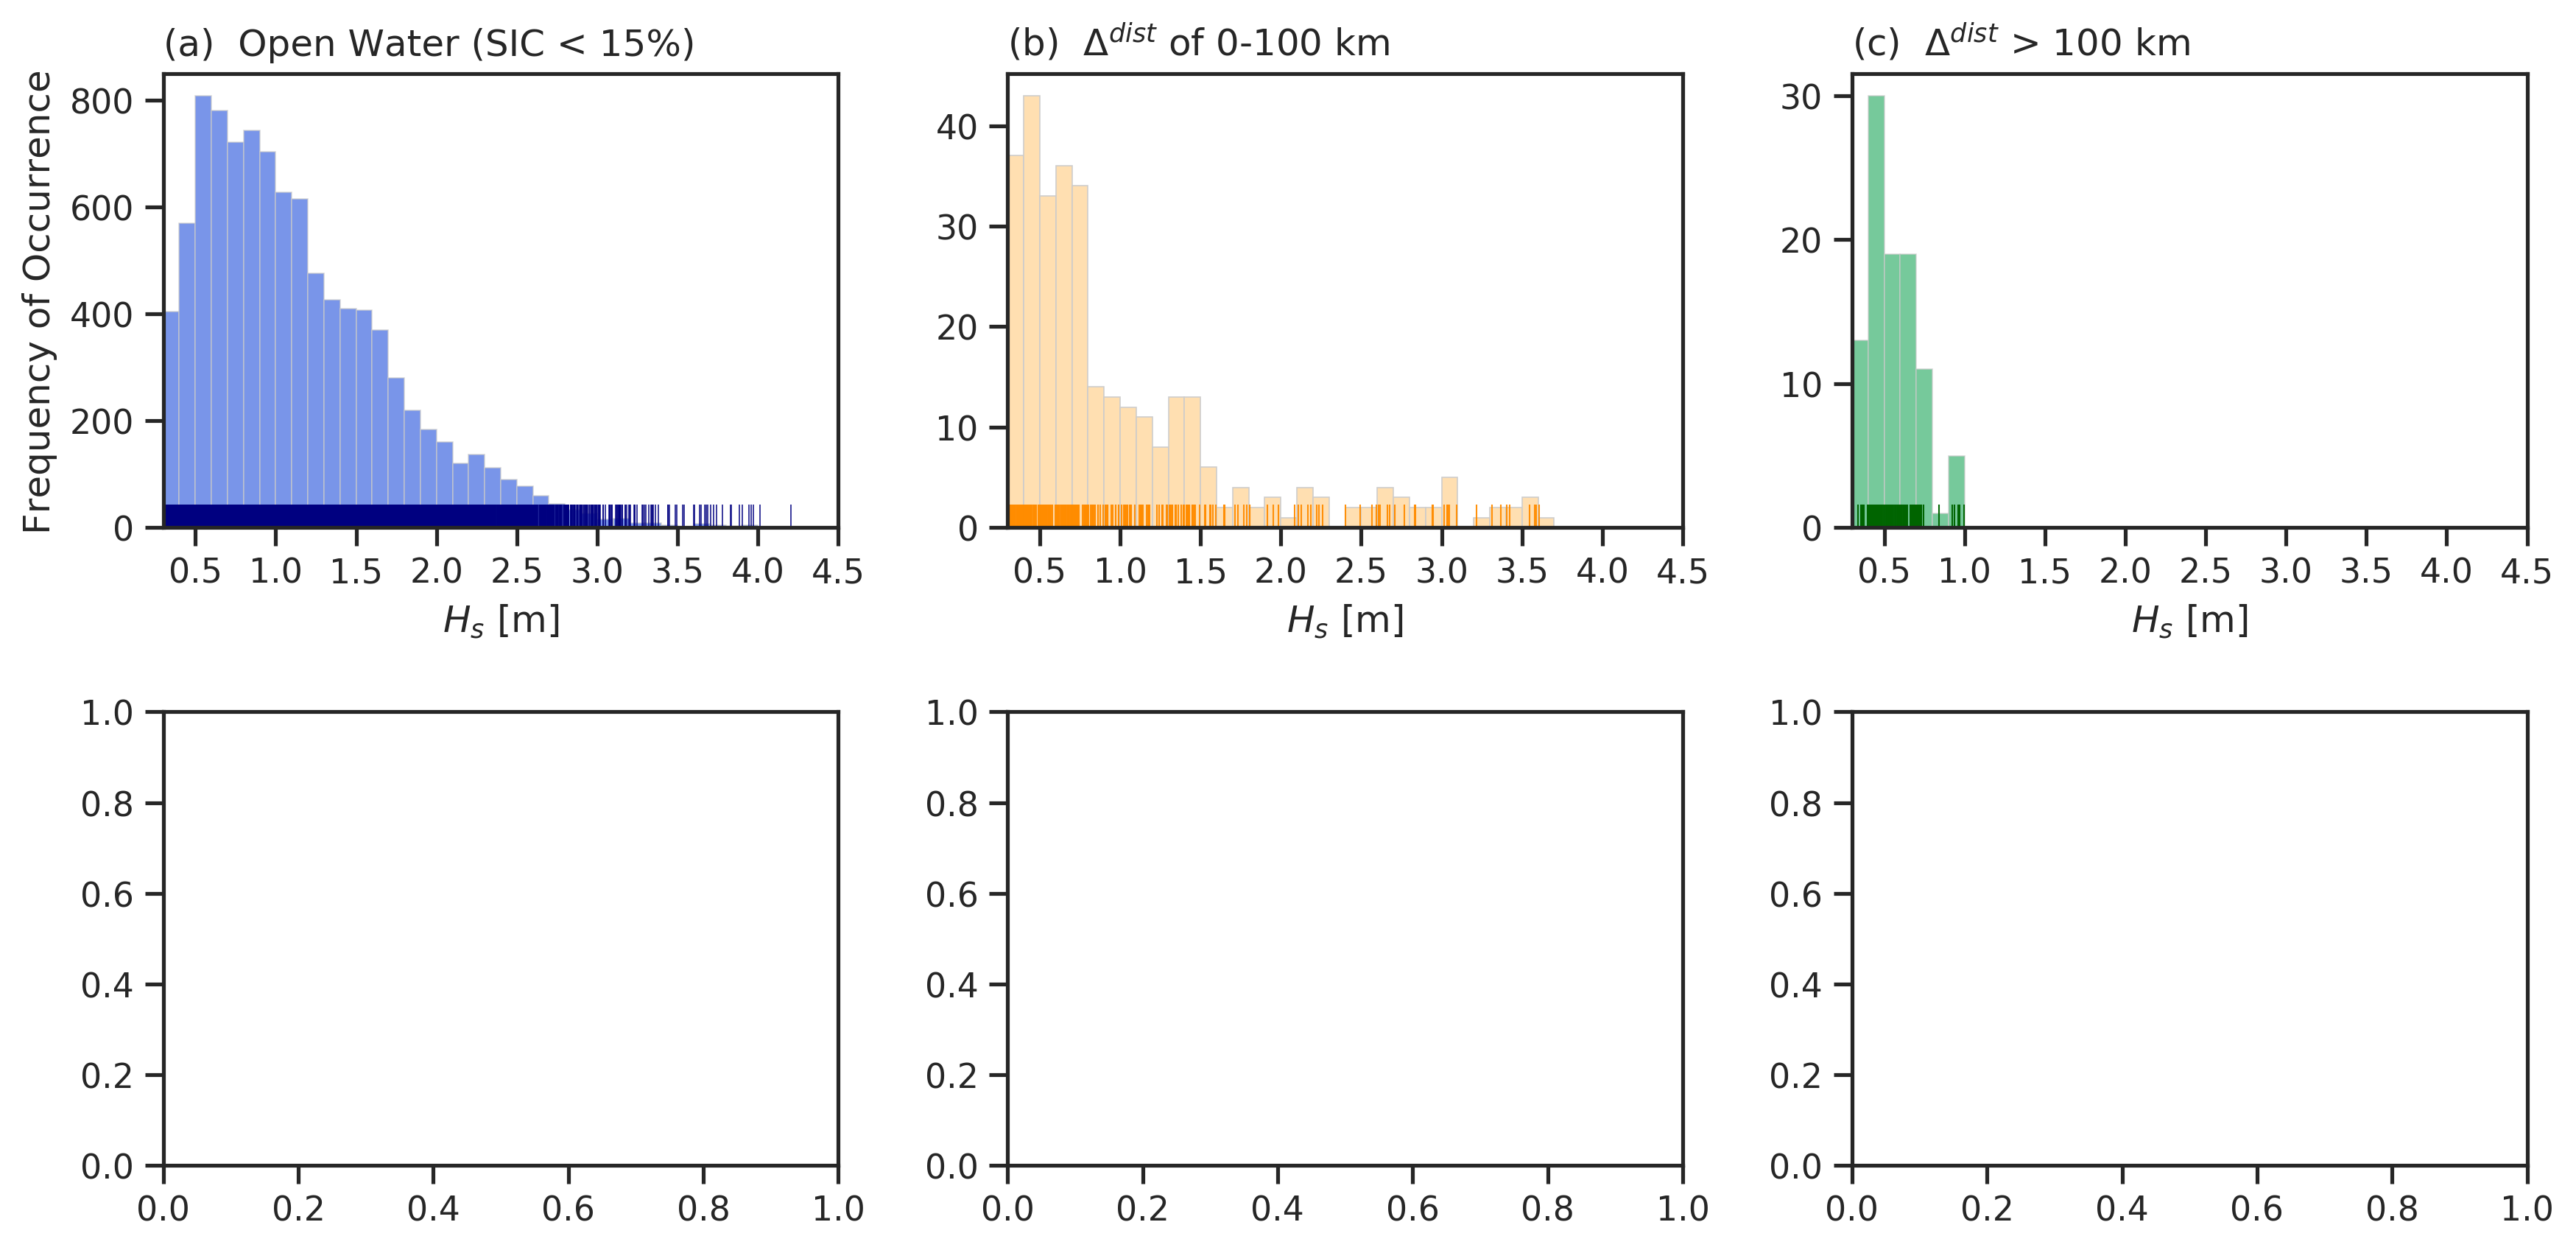

In [55]:
## 1d histogram obs and model
## BEAUFORT REGION

with sns.axes_style('ticks'):
    fig,ax = plt.subplots(2,3,figsize=(12,6),dpi=300) ## change to dpi 300 for press quality

    plt.sca(ax[0,0])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    obs_hs = bulk_ds_open.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='royalblue',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.7, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.9,'lw':0.4,'c':'navy'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(a)  Open Water (SIC < 15%)',loc='left')
    # plt.legend()

    ############
    plt.sca(ax[0,1])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    
    obs_hs = bulk_ds_0to100.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='navajowhite',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.95, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.95,'lw':0.5,'c':'darkorange'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    # plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(b)  $\Delta^{dist}$ of 0-100 km',loc='left')
    
    ############
    plt.sca(ax[0,2])
    setmin = 0.3
    setmax = 4.5
    nbins = 21*2
    
    obs_hs = bulk_ds_100.sigwaveheight#.values
    # obs_hs = obs_hs[~np.isnan(obs_hs)]
    
    sns.distplot(obs_hs,bins=nbins,kde=False,rug=True,
                       color='mediumseagreen',
                       label='BGOS-SODA',
                       hist_kws={'range':(setmin,setmax), 'edgecolor':'0.8','alpha':0.7, 'lw':0.4,'density':False},
                       rug_kws={'alpha':0.99,'lw':0.5,'c':'darkgreen'},
                       kde_kws={'linewidth':2,'bw':'scott','label':'','clip':[setmin,setmax]})
#     plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    # plt.ylabel('Frequency of Occurrence')
    plt.xlabel('$H_s$ [m]')
    plt.xticks(np.arange(0.5,4.5+0.1,0.5))
    plt.xlim(setmin,setmax)
    plt.title('(c)  $\Delta^{dist}$ > 100 km',loc='left')

    plt.tight_layout()
    plt.show()

In [127]:
def spectra_grid():
    plt.loglog()
    # plt.tick_params(axis='both', which='major', labelsize='x-small')
    # plt.tick_params(axis='both', which='minor', labelsize='x-small')
    plt.grid(True,which='both',alpha=0.5)
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.59)
    
    ### NOISE FLOOR
    x = np.linspace(0.001,1,10)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    plt.fill_between(x,ylower,yupper,alpha=0.1,color='0.1',zorder=6)
    

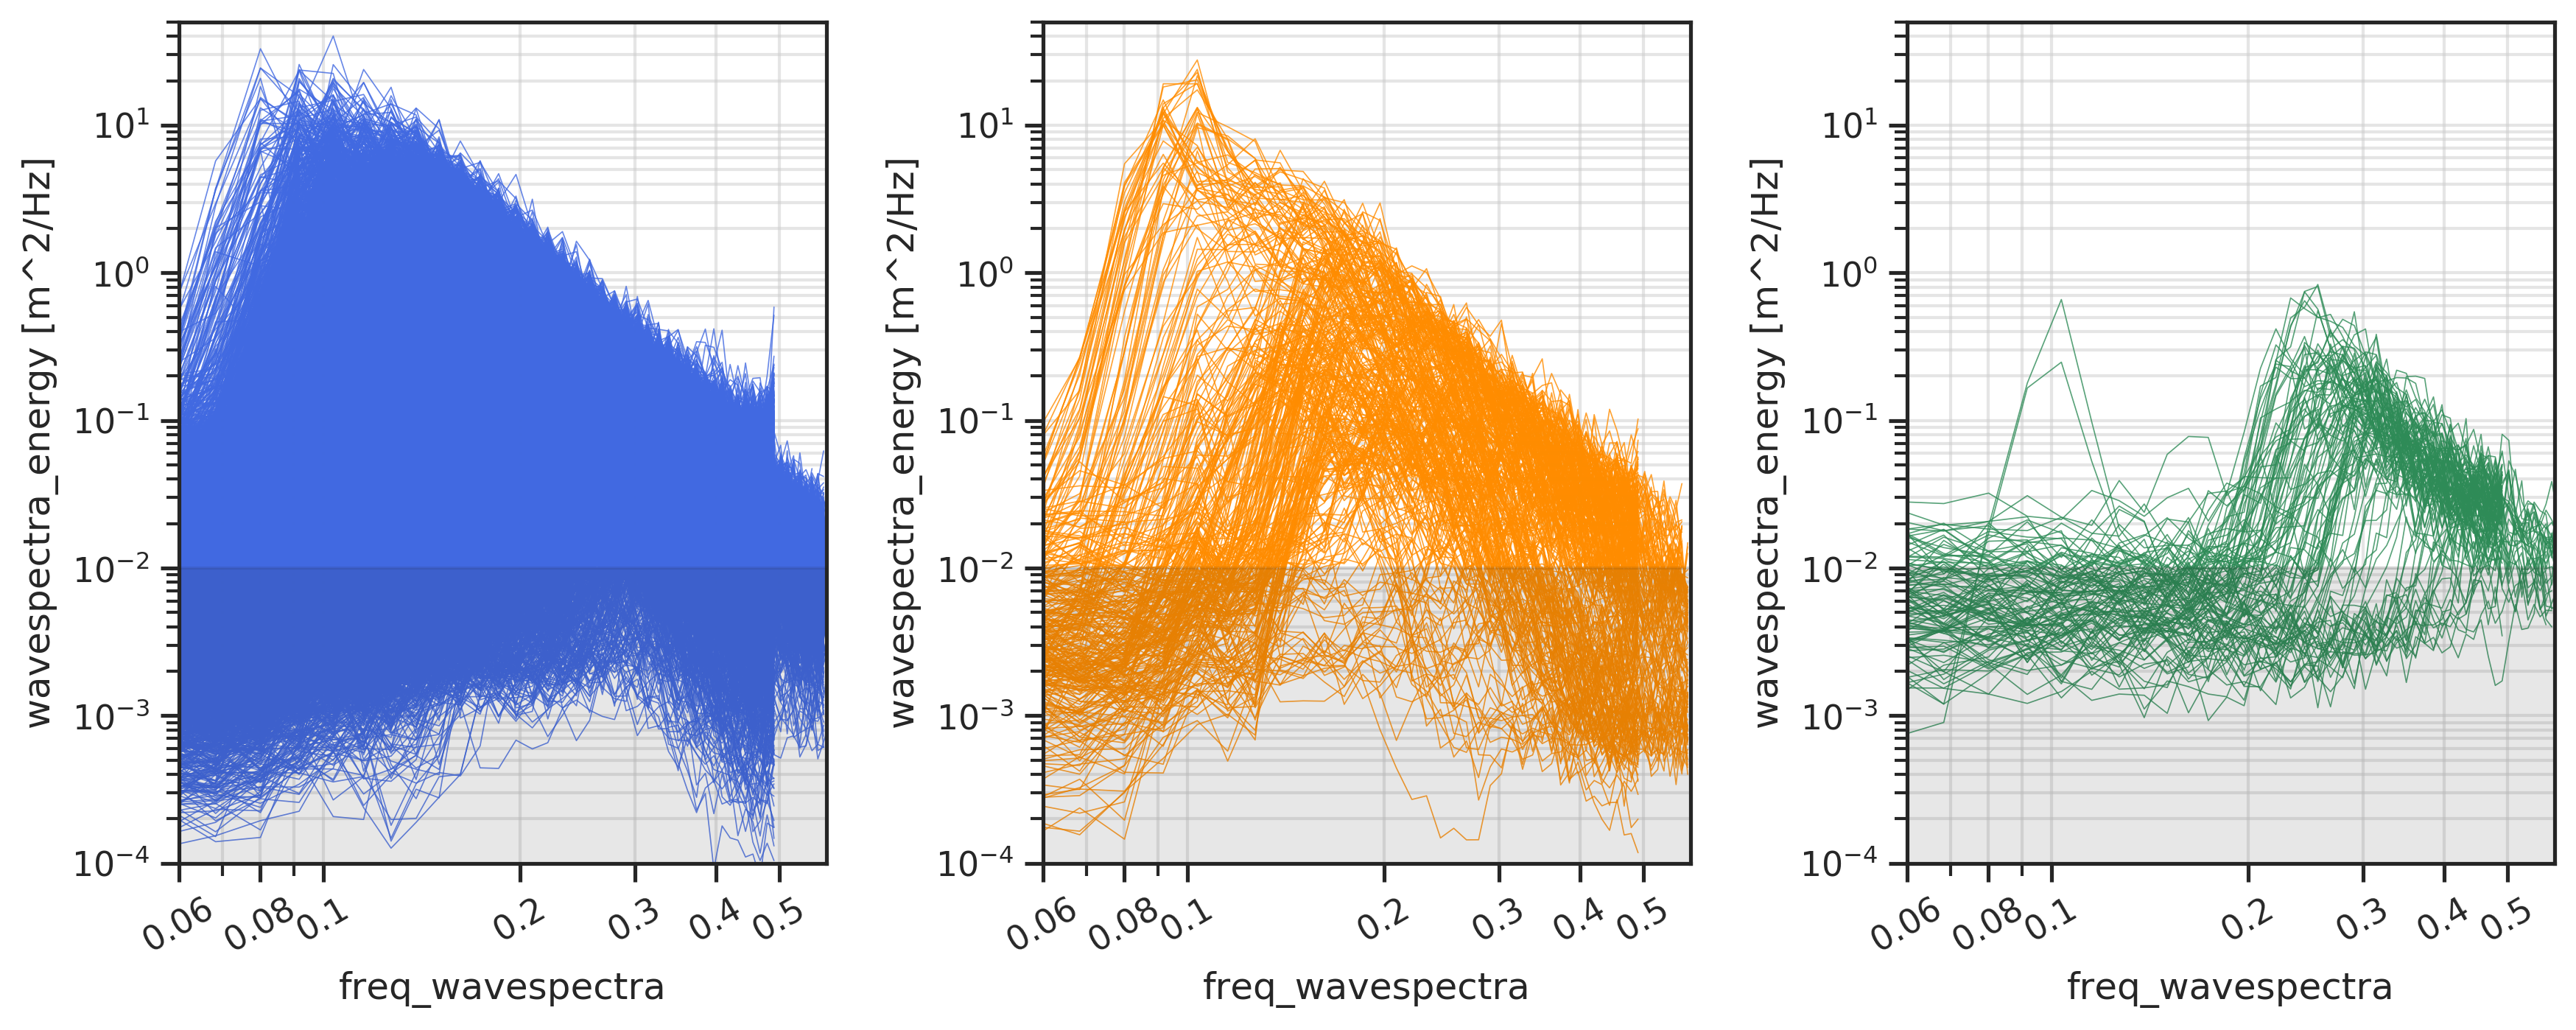

In [128]:
## 1d histogram obs and model
## BEAUFORT REGION

with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,3,figsize=(12,5),dpi=300) ## change to dpi 300 for press quality

    plt.sca(ax[0])
    specgroup = spec_d_open
    
    spectra_grid()
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    
    for key,val in specgroup.items():
        val.wavespectra_energy.plot.line(hue='time',add_legend=False,
                                                  lw=0.4,c='royalblue',alpha=0.1)

    ############
    plt.sca(ax[1])

    specgroup = spec_d_0to100
    
    spectra_grid()
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    
    for key,val in specgroup.items():
        val.wavespectra_energy.plot.line(hue='time',add_legend=False,
                                                  lw=0.4,c='darkorange',alpha=0.5)

    
    ############
    plt.sca(ax[2])

    specgroup = spec_d_100
    
    spectra_grid()
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    
    for key,val in specgroup.items():
        val.wavespectra_energy.plot.line(hue='time',add_legend=False,
                                                  lw=0.4,c='seagreen',alpha=0.5)

   

    plt.tight_layout()
    plt.show()

In [113]:
## tinker with colormaps
#https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/ 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

N=256
## stunted cmaps
blue = np.ones((N, 4))
blue[:, 0] = np.linspace(20,75/256, N)
blue[:, 1] = np.linspace(20,110/256, N)
blue[:, 2] = np.linspace(20,200/256, N)
blue_cmp = ListedColormap(blue)

# orange = np.ones((N, 4))
# orange[:, 0] = np.linspace(1,240/256, N)
# orange[:, 1] = np.linspace(1,146/256, N)
# orange[:, 2] = np.linspace(1,24/256, N)
# orange_cmp = ListedColormap(orange)

# green = np.ones((N, 4))
# green[:, 0] = np.linspace(1,30/256, N)
# green[:, 1] = np.linspace(1,154/256, N)
# green[:, 2] = np.linspace(1,46/256, N)
# green_cmp = ListedColormap(green)

In [116]:
val

<xarray.Dataset>
Dimensions:                  (bincenters_icehistogram: 21, freq_wavespectra: 42, time: 2481)
Coordinates:
  * time                     (time) datetime64[ns] 2015-08-12T09:31:01 ... 20...
  * bincenters_icehistogram  (bincenters_icehistogram) float64 0.0 0.5 ... 10.0
  * freq_wavespectra         (freq_wavespectra) float64 0.009766 ... 0.4902
    TLON                     (time) float32 219.82047 219.82047 ... 219.82047
    TLAT                     (time) float32 73.84869 73.84869 ... 73.84869
Data variables:
    icehistogram_Nobs        (time, bincenters_icehistogram) float64 457.0 .....
    wavespectra_energy       (time, freq_wavespectra) float64 0.0 0.0 ... 0.1037
    lat                      (time) float64 74.0 74.0 74.0 ... 74.0 74.0 74.0
    lon                      (time) float64 -140.0 -140.0 ... -140.0 -140.0
    icethickness             (time) float64 0.2629 0.2602 ... 0.5016 0.4947
    sigwaveheight            (time) float64 0.5416 0.5397 0.3491 ... 2.055 1.953
    peakwaveperiod           (time) float64 3.303 3.303 3.18 ... 7.211 6.649
    peakwavedirT             (time) float64 nan nan nan nan ... nan nan nan nan
    cdr                      (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    aice_d                   (time) float64 0.04414 0.04247 ... 0.1159 0.1192
    fp                       (time) float64 0.3027 0.3027 ... 0.1387 0.1504
    ef_eq                    (time, freq_wavespectra) float64 nan nan ... 0.1037
    cut_eq                   (time, freq_wavespectra) float64 nan nan ... nan
    N                        (time) int64 16 16 15 16 16 16 ... 25 25 25 25 25
    e0_mean                  (time) float64 0.001058 0.001396 ... 0.002196
    alpha                    (time) float64 0.02455 0.02907 ... 0.02247 0.02502
    u10est                   (time) float64 7.769 9.559 5.746 ... 13.05 13.9
    jra                      (time) float32 10.878944 10.878944 ... 14.186776
    rmse                     (time) float64 0.0002018 0.0003213 ... 0.0008981
    rmse_cut                 (time) float64 0.0002018 0.0003213 ... 0.0004281
    se                       (time) float64 1.482 2.201 1.65 ... 4.068 2.711
    rmsle                    (time) float64 0.0002015 0.0003209 ... 0.0008948
    rmsle_cut                (time) float64 0.0002015 0.0003209 ... 0.0004272
    obname                   (time) <U5 'bgosD' 'bgosD' ... 'bgosD' 'bgosD'

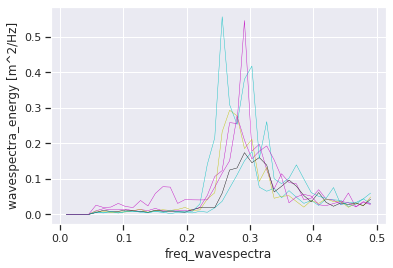

In [125]:
# from cycler import cycler

# colorlist = 

# cmap = mpl.colors.ListedColormap(colorlist)

# custom_cycler = cycler(color=blue_cmp.colors) #or simply color=colorlist

custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
                 cycler(lw=[1, 2, 3, 4]))

fig,ax = plt.subplots()

ax.set_prop_cycle(custom_cycler)

val.wavespectra_energy.plot.line(hue='time',add_legend=False,
                                                  lw=0.4,alpha=1)


# data.plot.line(ax=ax, x="x");

In [126]:
custom_cycler

(cycler('color', ['c', 'm', 'y', 'k']) + cycler('linewidth', [1, 2, 3, 4]))